In [295]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from joblib import dump

In [229]:
grades_dataset_path = "/Users/gowthami/Documents/pythonProjects/data/UMBC_Digital_Mentor_Admission_Dataset.csv"
grades_dataset = pd.read_csv(grades_dataset_path)
grades_dataset.head()

,Program,Department,High School GPA,SAT Score,ACT Score,Advanced Coursework (0-10),STEM Extracurriculars (0-10),Leadership Experience (0-10),Letters of Recommendation (0-10),Personal Statement Quality (0-10),Diversity/Inclusion Contribution (0-10),Transfer Student GPA,Admission Status
0,Information Systems,Information Systems,2.51,1224,7,6,10,10,4,4,10,0.85,Yes
1,Business Tech0logy Administration,Mechanical Engineering,2.67,921,3,1,2,4,5,9,3,2.15,Yes
2,Information Systems,Biological Sciences (in collaboration with COEIT),1.20,1460,23,1,9,6,6,5,5,3.07,Yes
3,Electrical Engineering,Information Systems,0.36,1131,27,10,1,10,9,3,3,0.53,No
4,Computer Engineering,Information Systems,2.02,806,30,10,7,1,9,1,9,2.31,Yes


In [ ]:
#Exploratory Data Analysis of the Digital Mentor Admission Dataset

In [231]:
print(grades_dataset['Program'].value_counts())
print("\n", grades_dataset['Department'].value_counts())
print("\n", grades_dataset['Admission Status'].value_counts())

Program
Mechanical Engineering                      654
Bioinformatics and Computational Biology    633
Computer Science                            624
Chemical Engineering                        613
Information Systems                         590
Business Tech0logy Administration           590
Environmental Engineering                   590
Electrical Engineering                      583
Cybersecurity Informatics                   566
Computer Engineering                        557
Name: count, dtype: int64

 Department
Mechanical Engineering                               1229
Biological Sciences (in collaboration with COEIT)    1218
Computer Science and Electrical Engineering          1210
Information Systems                                  1191
Chemical, Biochemical & Environmental Engineering    1152
Name: count, dtype: int64

 Admission Status
Yes    4223
No     1777
Name: count, dtype: int64


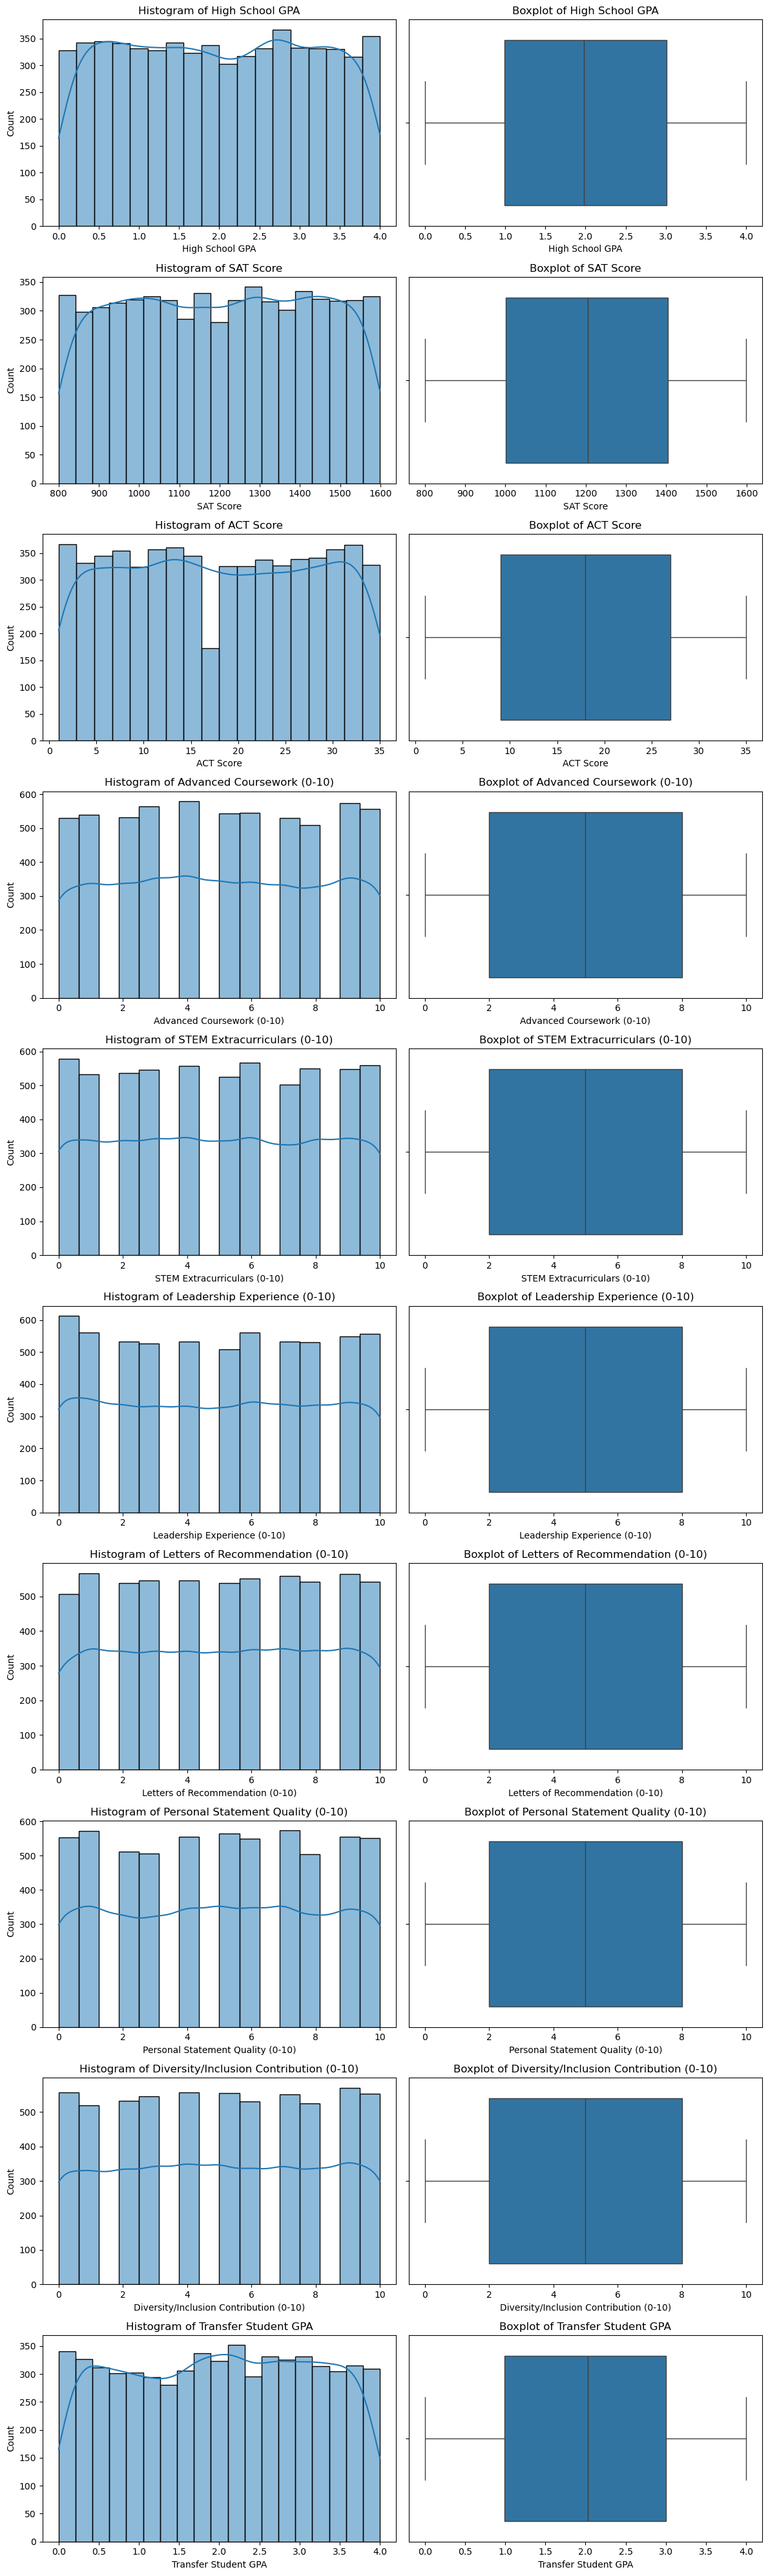

In [233]:
# Plot histograms and boxplots for the numerical columns
fig, axes = plt.subplots(len(numerical_cols), 2, figsize=(12, len(numerical_cols) * 4))
for i, col in enumerate(numerical_cols):
    sns.histplot(grades_dataset[col], ax=axes[i, 0], kde=True)
    axes[i, 0].set_title(f'Histogram of {col}')
    sns.boxplot(x=grades_dataset[col], ax=axes[i, 1])
    axes[i, 1].set_title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

In [235]:
# Calculate skewness of each numerical feature
skewness = grades_dataset[numerical_cols].apply(lambda x: skew(x))
print("Skewness of numerical features:")
print(skewness)

Skewness of numerical features:
High School GPA                            0.005957
SAT Score                                 -0.015217
ACT Score                                  0.009137
Advanced Coursework (0-10)                 0.008359
STEM Extracurriculars (0-10)               0.005134
Leadership Experience (0-10)               0.006353
Letters of Recommendation (0-10)          -0.009493
Personal Statement Quality (0-10)         -0.009315
Diversity/Inclusion Contribution (0-10)   -0.009955
Transfer Student GPA                      -0.029394
dtype: float64


In [237]:
# Function to find outliers using IQR
def find_outliers(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    return outliers

# Apply to each feature and print outliers
for col in numerical_cols:
    outliers = find_outliers(grades_dataset, col)
    print(f"Outliers in {col}:", outliers.index.tolist())

Outliers in High School GPA: []
Outliers in SAT Score: []
Outliers in ACT Score: []
Outliers in Advanced Coursework (0-10): []
Outliers in STEM Extracurriculars (0-10): []
Outliers in Leadership Experience (0-10): []
Outliers in Letters of Recommendation (0-10): []
Outliers in Personal Statement Quality (0-10): []
Outliers in Diversity/Inclusion Contribution (0-10): []
Outliers in Transfer Student GPA: []


In [239]:
# Correcting skewness example using log transformation (where suitable)

for col in numerical_cols:
    if skew(grades_dataset[col]) > 0 or skew(grades_dataset[col]) < 0:
        grades_dataset[col] = np.log1p(grades_dataset[col])

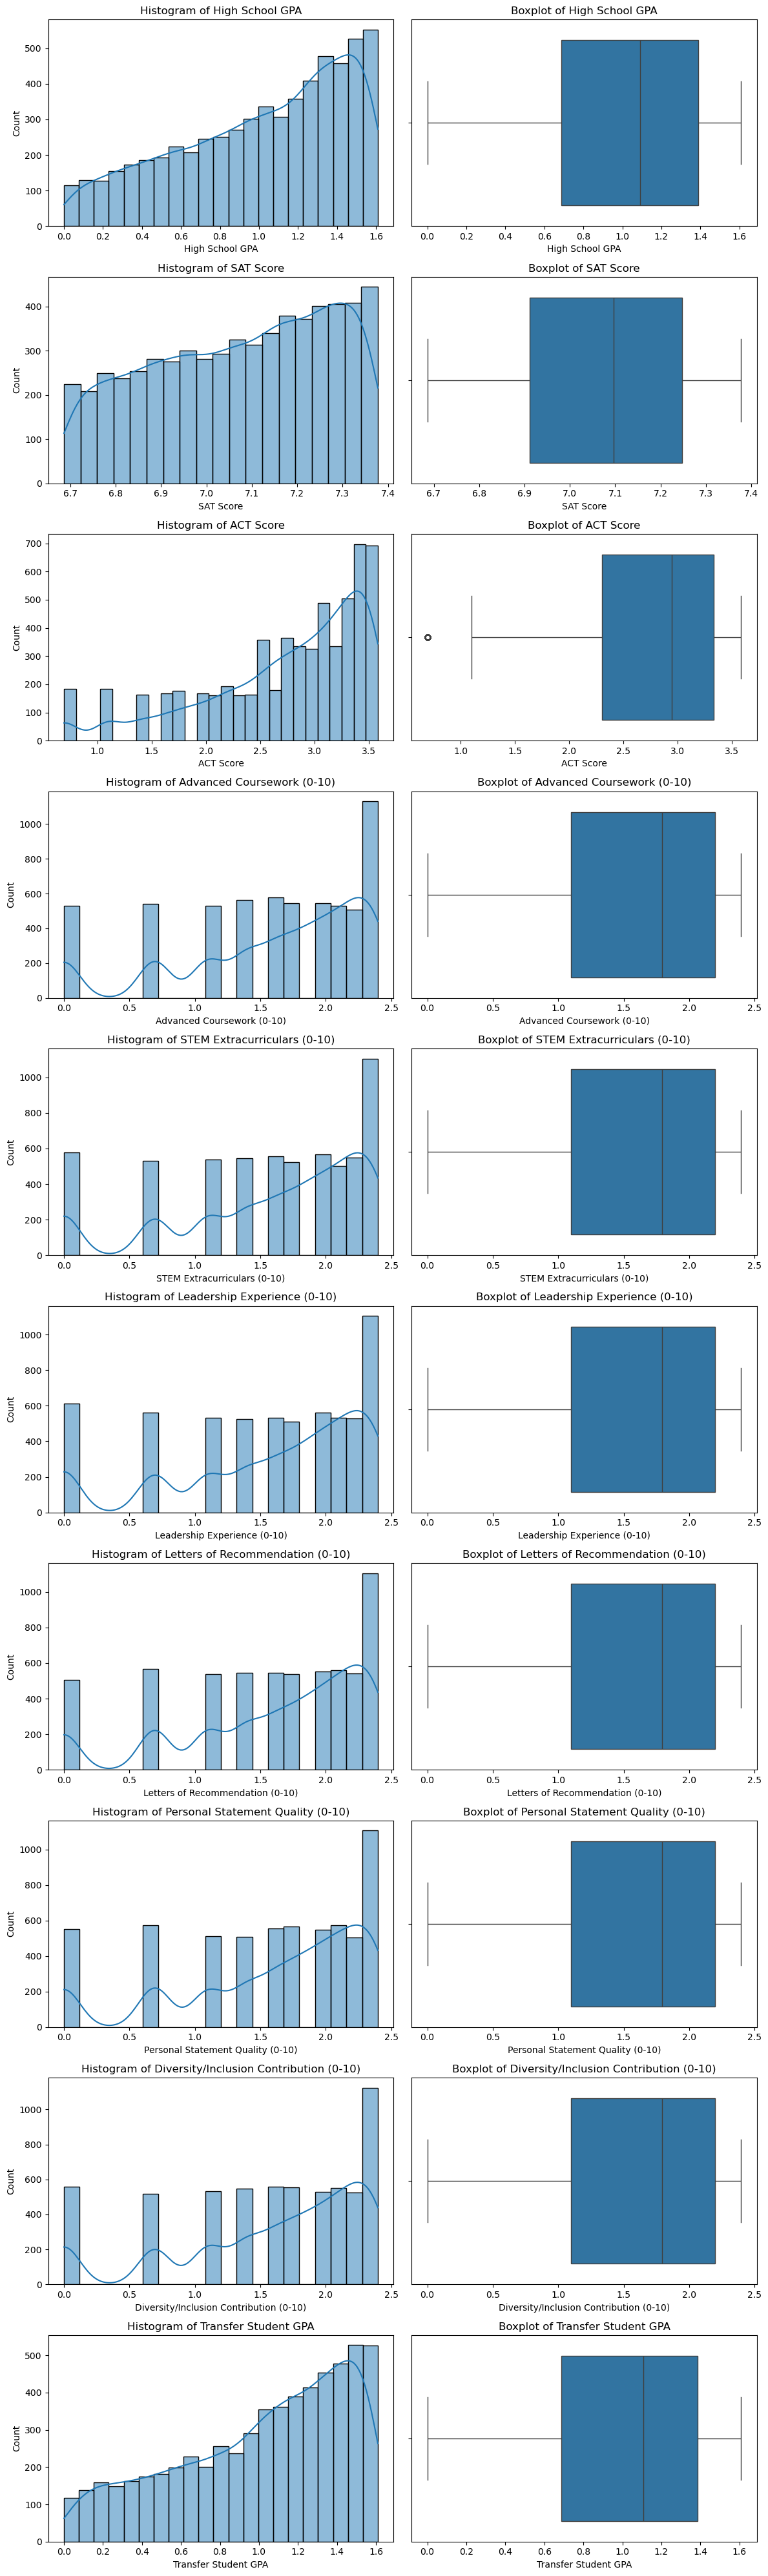

In [241]:
# Plot histograms and boxplots
fig, axes = plt.subplots(len(numerical_cols), 2, figsize=(12, len(numerical_cols) * 4))
for i, col in enumerate(numerical_cols):
    sns.histplot(grades_dataset[col], ax=axes[i, 0], kde=True)
    axes[i, 0].set_title(f'Histogram of {col}')
    sns.boxplot(x=grades_dataset[col], ax=axes[i, 1])
    axes[i, 1].set_title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

In [291]:
# One-hot encode 'Program' and 'Department' columns
grades_dataset_encoded = pd.get_dummies(grades_dataset, columns=['Program', 'Department'])

# Convert 'Admission Status' to binary (1 for 'Yes', 0 for 'No')
grades_dataset_encoded['Admission report'] = grades_dataset['Admission Status'].apply(lambda x: 1 if x == 'Yes' else 0)

# Display the first few rows to confirm changes
grades_dataset_encoded.head()

,High School GPA,SAT Score,ACT Score,Advanced Coursework (0-10),STEM Extracurriculars (0-10),Leadership Experience (0-10),Letters of Recommendation (0-10),Personal Statement Quality (0-10),Diversity/Inclusion Contribution (0-10),Transfer Student GPA,...,Program_Electrical Engineering,Program_Environmental Engineering,Program_Information Systems,Program_Mechanical Engineering,Department_Biological Sciences (in collaboration with COEIT),"Department_Chemical, Biochemical & Environmental Engineering",Department_Computer Science and Electrical Engineering,Department_Information Systems,Department_Mechanical Engineering,Admission report
0,1.255616,7.110696,2.079442,1.945910,2.397895,2.397895,1.609438,1.609438,2.397895,0.615186,...,False,False,True,False,False,False,False,True,False,1
1,1.300192,6.826545,1.386294,0.693147,1.098612,1.609438,1.791759,2.302585,1.386294,1.147402,...,False,False,False,False,False,False,False,False,True,1
2,0.788457,7.286876,3.178054,0.693147,2.302585,1.945910,1.945910,1.791759,1.791759,1.403643,...,False,False,True,False,True,False,False,False,False,1
3,0.307485,7.031741,3.332205,2.397895,0.693147,2.397895,2.302585,1.386294,1.386294,0.425268,...,True,False,False,False,False,False,False,True,False,0
4,1.105257,6.693324,3.433987,2.397895,2.079442,0.693147,2.302585,0.693147,2.302585,1.196948,...,False,False,False,False,False,False,False,True,False,1


In [305]:
# Define the features and the target
X = grades_dataset_encoded.drop('Admission report', axis=1)
y = grades_dataset_encoded['Admission report']

# Split the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [309]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from joblib import dump

# Identify categorical columns (object and bool types)
categorical_columns = X_train.select_dtypes(include=['object', 'bool']).columns

# Create a pipeline to preprocess and scale the data
scaler_pipeline = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ], remainder='passthrough')),
    ('scaler', StandardScaler())
])

# Fit the pipeline to the training data and transform
X_train_scaled = scaler_pipeline.fit_transform(X_train)
X_test_scaled = scaler_pipeline.transform(X_test)

# Save the pipeline to disk
model_filename = "/Users/gowthami/Documents/pythonProjects/data/scaler_pipeline.joblib"
dump(scaler_pipeline, model_filename)

print(f"Model saved to {model_filename}")


Model saved to /Users/gowthami/Documents/pythonProjects/data/scaler_pipeline.joblib


In [311]:
X_test.columns

Index(['High School GPA', 'SAT Score', 'ACT Score',
       'Advanced Coursework (0-10)', 'STEM Extracurriculars (0-10)',
       'Leadership Experience (0-10)', 'Letters of Recommendation (0-10)',
       'Personal Statement Quality (0-10)',
       'Diversity/Inclusion Contribution (0-10)', 'Transfer Student GPA',
       'Admission Status', 'Admission Accepeted', 'Admission Accepted',
       'Program_Bioinformatics and Computational Biology',
       'Program_Business Tech0logy Administration',
       'Program_Chemical Engineering', 'Program_Computer Engineering',
       'Program_Computer Science', 'Program_Cybersecurity Informatics',
       'Program_Electrical Engineering', 'Program_Environmental Engineering',
       'Program_Information Systems', 'Program_Mechanical Engineering',
       'Department_Biological Sciences (in collaboration with COEIT)',
       'Department_Chemical, Biochemical & Environmental Engineering',
       'Department_Computer Science and Electrical Engineering',
   

In [313]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

In [315]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_smote, y_train_smote)
y_pred_rf = rf.predict(X_test_scaled)

print("Random Forest Accuracy on test set:", accuracy_score(y_test, y_pred_rf))
print("Classification Report for Random Forest:\n", classification_report(y_test, y_pred_rf))

Random Forest Accuracy on test set: 1.0
Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       354
           1       1.00      1.00      1.00       846

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200



In [317]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_smote, y_train_smote)
y_pred_lr = lr.predict(X_test_scaled)

print("Logistic Regression Accuracy on test set:", accuracy_score(y_test, y_pred_lr))
print("Classification Report for Logistic Regression:\n", classification_report(y_test, y_pred_lr))

Logistic Regression Accuracy on test set: 1.0
Classification Report for Logistic Regression:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       354
           1       1.00      1.00      1.00       846

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200



In [355]:
# Calculate the scale_pos_weight based on the original y_train
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Initialize and train the XGBoost model without scale_pos_weight because SMOTE data is balanced
xgb = XGBClassifier(eval_metric='logloss')  # No scale_pos_weight needed for balanced data
xgb.fit(X_train_smote, y_train_smote)  # Using SMOTE balanced data

# Make predictions on the test set
y_pred_xgb = xgb.predict(X_test_scaled)

# Evaluate the model's performance
print("XGBoost Accuracy on test set:", accuracy_score(y_test, y_pred_xgb))
print("Classification Report for XGBoost:\n", classification_report(y_test, y_pred_xgb))

XGBoost Accuracy on test set: 1.0
Classification Report for XGBoost:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       354
           1       1.00      1.00      1.00       846

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200



In [323]:
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 6],
    'subsample': [0.8, 0.9, 1.0]
}

In [357]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Perform GridSearchCV for XGBoost
grid_xgb = GridSearchCV(
    estimator=XGBClassifier(eval_metric='logloss'),  # Added use_label_encoder=False to suppress warnings
    param_grid=param_grid_xgb,  # Ensure param_grid_xgb is already defined
    cv=5,
    scoring='accuracy',
    verbose=1
)

# Fit the grid search to the data
grid_xgb.fit(X_train_smote, y_train_smote)

# Output the best parameters and the best score
print("Best parameters for XGBoost:", grid_xgb.best_params_)
print("Best score for XGBoost:", grid_xgb.best_score_)


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters for XGBoost: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
Best score for XGBoost: 1.0


In [359]:
# Assuming grid_lr, grid_rf, grid_xgb are the GridSearchCV objects for LogisticRegression, RandomForest, and XGBoost respectively
best_params_lr = grid_lr.best_params_
best_params_rf = grid_rf.best_params_
best_params_xgb = grid_xgb.best_params_

# Initialize the models with the best parameters
lr_best = LogisticRegression(**best_params_lr)
rf_best = RandomForestClassifier(**best_params_rf)
xgb_best = XGBClassifier(**best_params_xgb)

In [361]:
# Create the voting classifier
voting_clf = VotingClassifier(
    estimators=[('lr', lr_best), ('rf', rf_best), ('xgb', xgb_best)],
    voting='soft'
)

In [363]:
# Train the ensemble model
voting_clf.fit(X_train_smote, y_train_smote)

# Predict on the test set
y_pred = voting_clf.predict(X_test_scaled)

# Evaluate the ensemble model
print("Accuracy of Ensemble Model:", accuracy_score(y_test, y_pred))
print("Classification Report for Ensemble Model:\n", classification_report(y_test, y_pred))

Accuracy of Ensemble Model: 1.0
Classification Report for Ensemble Model:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       354
           1       1.00      1.00      1.00       846

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200



In [365]:
from joblib import dump

# Save the model to disk
model_filename = "/Users/gowthami/Documents/pythonProjects/data/scaler_pipeline.joblib"
dump(voting_clf, model_filename)

print(f"Model saved to {model_filename}")

Model saved to /Users/gowthami/Documents/pythonProjects/data/scaler_pipeline.joblib
